# Check Bad Predictions

### Author: Xuying Ning
### All copyright reserved.

In [4]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import os

In [6]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 50
).eval().to(device)
resnet.load_state_dict(torch.load('model_parameter0.pth',map_location="cuda:0"), strict=False)

<All keys matched successfully>

In [7]:
class CustomImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dira (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        # image = image.view((224,224,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # # image = np.transpose(image,(1,2,0)) 
        label = self.landmarks_frame.iloc[idx, 1]
        label = np.array(label)
        if self.transform:
            image = self.transform(image)
        return image,label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  6 Prediction :  14 , Score:  21810.955
True Label :  34 Prediction :  45 , Score:  1141.5693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  37 Prediction :  33 , Score:  2367.9438
True Label :  0 Prediction :  21 , Score:  1489.3324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  13 Prediction :  46 , Score:  6553.3657


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  26 Prediction :  34 , Score:  486.4656


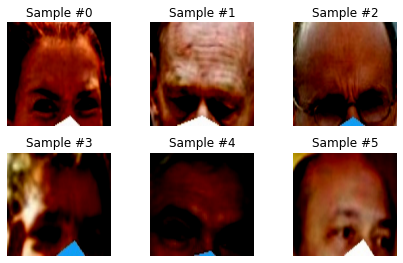

In [8]:
from facenet_pytorch import fixed_image_standardization, training
from torch.utils.data import DataLoader
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((160,160)),
    fixed_image_standardization
])
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='crop-mask-face/test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
sample = 0 
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        # print(inputs.shape)
        classes = classes.to(device)
        outputs = resnet(inputs)
        ps = torch.exp(outputs)
        topk, topclass = ps.topk(1, dim=1)
        if sample < 6:
            if classes[0].item() != topclass.cpu().numpy()[0][0]:
                print('True Label : ', classes[0].item(), "Prediction : ", topclass.cpu().numpy()[0][0], ", Score: ", topk.cpu().numpy()[0][0])
                ax = plt.subplot(2, 3, sample + 1)
                plt.tight_layout()
                ax.set_title('Sample #{}'.format(sample))
                ax.axis('off')
                plt.imshow(inputs[0].cpu().permute(1,2,0))
                sample += 1

Most of the bad classification is due to side face and small number of training samples.